In [ ]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 1. Data Import and Cleaning

In [2]:
statement_df = pd.read_csv("data\\statement_fact_20250325.csv")
statement_df['billing_cycle_date'] = pd.to_datetime(statement_df['billing_cycle_date'])
statement_df = statement_df.sort_values(by=['current_account_nbr','billing_cycle_date'], ascending=True).reset_index(drop=True)

# Convert 'billing_cycle_date' to datetime format and extract the year and month only
statement_df['billing_cycle_date'] = pd.to_datetime(statement_df['billing_cycle_date']).dt.to_period('M').astype(str)
statement_df['return_check_cnt_last_mth'] = statement_df['return_check_cnt_last_mth'].replace(99, 0)

# Filter out records with 'billing_cycle_month' earlier than 2024-10
statement_df_filtered = statement_df[statement_df['billing_cycle_date'] >= '2024-10']
statement_df_filtered = statement_df_filtered.drop_duplicates(subset=['current_account_nbr', 'billing_cycle_date'], keep='last')

In [3]:
statement_df_filtered.head()

,current_account_nbr,billing_cycle_date,payment_hist_1_12_mths,return_check_cnt_2yr,return_check_cnt_last_mth,return_check_cnt_py,return_check_cnt_total,return_check_cnt_ytd,prev_balance
62,00iP5U82D8XwVQ9G,2024-10,QQQQQQQQQQQQ,0,0,0,0,0,421.16
63,00iP5U82D8XwVQ9G,2024-11,QQQQQQQQQQQQ,0,0,0,0,0,499.20
64,00iP5U82D8XwVQ9G,2024-12,QQQQQQQQQQQQ,0,0,0,0,0,616.01
65,00iP5U82D8XwVQ9G,2025-01,QQQQQQQQQQQQ,0,0,0,0,0,661.86
66,00iP5U82D8XwVQ9G,2025-02,QQQQQQQQQQQQ,0,0,0,0,0,474.19


In [4]:
account_df = pd.read_csv("data\\account_dim_20250325.csv")
cols_to_drop = [
    'date_in_collection',
    'special_finance_charge_ind',
    'overlimit_type_flag',
    'ebill_ind',
    'pscc_ind',
    'payment_hist_1_12_mths',
    'payment_hist_13_24_mths'
]
account_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
for col in ['open_date', 'card_activation_date']:
    if col in account_df.columns:
        account_df[f'{col}_year_month'] = account_df[col].astype(str).str[:7]
        account_df.drop(columns=col, inplace=True)

In [5]:
account_df['card_activation_flag'] = account_df['card_activation_flag'].apply(
    lambda x: 'Activated' if str(x).strip() == '0' else 'Non-Activated'
)
account_df['High_Spending'] = account_df['employee_code'].apply(lambda x: 1 if str(x).strip() == 'H' else 0)
account_df.drop(columns=['employee_code'], inplace=True)
for col in ['open_date_year_month', 'card_activation_date_year_month']:
    if col in account_df.columns:
        account_df[col] = account_df[col].replace('nan', pd.NA)
        account_df[col] = pd.to_datetime(account_df[col], format='%Y-%m', errors='coerce')

In [6]:
duplicates = account_df[account_df.duplicated(subset=['current_account_nbr'], keep=False)]
duplicates

,current_account_nbr,client_id,card_activation_flag,external_status_reason_code,ext_status_reason_cd_desc,account_card_type,open_date_year_month,card_activation_date_year_month,High_Spending


In [7]:
account_df.head()

,current_account_nbr,client_id,card_activation_flag,external_status_reason_code,ext_status_reason_cd_desc,account_card_type,open_date_year_month,card_activation_date_year_month,High_Spending
0,nTgalbpd5Rsol7CA,YCTHAA278DC,Non-Activated,0,NaN,DUAL CARD,2020-07-01,NaT,0
1,xYaLrD9IvmbVl1PB,CCSP489PLCC,Activated,0,NaN,DUAL CARD,2024-07-01,2024-08-01,0
2,JM78WNziiRWgmL8e,HGBHARRFT984,Activated,0,NaN,PLCC,2024-05-01,2024-05-01,0
3,bv4NLVhWTGCf8KgC,OSELW263,Activated,0,NaN,PLCC,2024-07-01,2024-09-01,0
4,nrXceQabYIHo31lp,HGBHARRFT984,Activated,0,NaN,PLCC,2024-09-01,2024-09-01,0


In [8]:
rams_batch_df = pd.read_csv("data\\rams_batch_cur_20250325.csv")
rams_batch_df['cu_processing_date'] = pd.to_datetime(rams_batch_df['cu_processing_date']).dt.to_period('M').astype(str)
rams_batch_df = rams_batch_df.sort_values(by=['cu_account_nbr','cu_processing_date'], ascending=True).reset_index(drop=True)
account_snapshot_df= rams_batch_df[['cu_account_nbr','cu_processing_date','cu_cur_balance','cu_crd_line','cu_cash_line_am','cu_otb','ca_current_utilz','ca_avg_utilz_lst_3_mnths','ca_avg_utilz_lst_6_mnths',
                                    'rb_new_bhv_scr','cu_crd_bureau_scr','rb_crd_gr_new_crd_gr',
                                    'cu_nbr_days_dlq','cu_cur_nbr_due','ca_max_dlq_lst_6_mnths','ca_nsf_count_lst_12_months',
                                    'mo_tot_sales_array_1','mo_tot_sales_array_2','mo_tot_sales_array_3','mo_tot_sales_array_4','mo_tot_sales_array_5','mo_tot_sales_array_6',
                                    'cu_line_incr_excl_flag','cu_nbr_of_plastics'
                                    ]]
account_snapshot_df['ca_current_utilz']=rams_batch_df['ca_current_utilz']*0.01
account_snapshot_df['ca_avg_utilz_lst_3_mnths']=rams_batch_df['ca_avg_utilz_lst_3_mnths']*0.01
account_snapshot_df['ca_avg_utilz_lst_6_mnths']=rams_batch_df['ca_avg_utilz_lst_6_mnths']*0.01
account_snapshot_df = account_snapshot_df.drop_duplicates(subset=['cu_account_nbr', 'cu_processing_date'], keep='last')

In [9]:
account_snapshot_df.head()

,cu_account_nbr,cu_processing_date,cu_cur_balance,cu_crd_line,cu_cash_line_am,cu_otb,ca_current_utilz,ca_avg_utilz_lst_3_mnths,ca_avg_utilz_lst_6_mnths,rb_new_bhv_scr,cu_crd_bureau_scr,rb_crd_gr_new_crd_gr,cu_nbr_days_dlq,cu_cur_nbr_due,ca_max_dlq_lst_6_mnths,ca_nsf_count_lst_12_months,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,cu_line_incr_excl_flag,cu_nbr_of_plastics
0,00iP5U82D8XwVQ9G,2024-10,539.20,3500,0,2980.80,0.15,0.11,0.11,744,788,R,0,0,0,0,530.32,441.16,408.74,192.66,176.19,251.44,N,1
1,00iP5U82D8XwVQ9G,2024-11,656.01,3500,0,2863.99,0.18,0.15,0.12,738,788,R,0,0,0,0,638.37,530.32,441.16,408.74,192.66,176.19,N,1
2,00iP5U82D8XwVQ9G,2024-12,701.86,3500,0,2818.14,0.19,0.17,0.12,735,788,R,0,0,0,0,681.86,638.37,530.32,441.16,408.74,192.66,N,1
3,00iP5U82D8XwVQ9G,2025-01,514.19,3500,0,3005.81,0.14,0.17,0.14,735,793,R,0,0,0,0,494.19,681.86,638.37,530.32,441.16,408.74,N,1
4,00iP5U82D8XwVQ9G,2025-02,354.10,3500,0,3165.90,0.10,0.14,0.14,742,793,R,0,0,0,0,334.10,494.19,681.86,638.37,530.32,441.16,N,1


In [10]:
fraud_claim_case_df = pd.read_csv("data\\fraud_claim_case_20250325.csv")
fraud_claim_tran_df = pd.read_csv("data\\fraud_claim_tran_20250325.csv")

In [11]:
fraud_df = pd.merge(
    fraud_claim_tran_df,
    fraud_claim_case_df,
    on=["current_account_nbr","case_id"],
    how="left"  # keep all transaction records, even if some don't match a case
)

fraud_df.drop(columns=['transaction_am','open_date','close_date','reopen_date','net_fraud_amt'], inplace=True)
fraud_df['transaction_dt'] = pd.to_datetime(fraud_df['transaction_dt']).dt.to_period('D').astype(str)

In [12]:
syf_id_df = pd.read_csv("data\\syf_id_20250325.csv")
syf_id_df = syf_id_df[['account_nbr_pty','ds_id','confidence_level']]

In [13]:
syf_id_df.head()

,account_nbr_pty,ds_id,confidence_level
0,7CvIGUYp2era9NFA,O4khZfhXa2CcmIM9lI7ESrQRM1ypTAkH,HIGH
1,8631QmQa2F5U84TQ,An8eibS3OUqawbhjkVaUWOA95FbPJnDO,HIGH
2,KMGjSyDldINUEYTS,I428G9M27M8qBRi1LC2Uu6Jiq4xdw3md,HIGH
3,pCz3B3yfpXlORZcD,0nM2JXxAp6Kw8xtF7N0TOw9nMqXzRsh7,HIGH
4,FSglswDATksbQMh5,IQF02sVHSPZQWHetdS2lcLUCrXGCrvXy,HIGH


merge datasets

In [14]:
print(statement_df_filtered.shape)
print(account_snapshot_df.shape)
print(account_df.shape)
print(fraud_df.shape)

(91874, 9)
(94125, 24)
(18070, 9)
(202, 5)


In [15]:
merged_df = pd.merge(statement_df_filtered, account_snapshot_df, how='outer', left_on='current_account_nbr', right_on='cu_account_nbr')
merged_df = merged_df[merged_df['billing_cycle_date']==merged_df['cu_processing_date']]
merged_df = pd.merge(merged_df, account_df, how='left', on='current_account_nbr')
fraud_df = fraud_df.drop_duplicates(subset='current_account_nbr')
merged_df = pd.merge(merged_df, fraud_df, how='left', on='current_account_nbr')
merged_df = pd.merge(merged_df, syf_id_df, how='left', left_on='current_account_nbr', right_on='account_nbr_pty')
merged_df.drop(columns=['cu_account_nbr','account_nbr_pty'], inplace=True)
merged_df.shape

(91703, 46)

In [16]:
duplicates = merged_df[merged_df.duplicated(subset=['current_account_nbr', 'billing_cycle_date'], keep=False)]
duplicates

,current_account_nbr,billing_cycle_date,payment_hist_1_12_mths,return_check_cnt_2yr,return_check_cnt_last_mth,return_check_cnt_py,return_check_cnt_total,return_check_cnt_ytd,prev_balance,cu_processing_date,cu_cur_balance,cu_crd_line,cu_cash_line_am,cu_otb,ca_current_utilz,ca_avg_utilz_lst_3_mnths,ca_avg_utilz_lst_6_mnths,rb_new_bhv_scr,cu_crd_bureau_scr,rb_crd_gr_new_crd_gr,cu_nbr_days_dlq,cu_cur_nbr_due,ca_max_dlq_lst_6_mnths,ca_nsf_count_lst_12_months,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,cu_line_incr_excl_flag,cu_nbr_of_plastics,client_id,card_activation_flag,external_status_reason_code,ext_status_reason_cd_desc,account_card_type,open_date_year_month,card_activation_date_year_month,High_Spending,case_id,transaction_dt,reported_date,gross_fraud_amt,ds_id,confidence_level


In [17]:
merged_df = merged_df[merged_df['ca_avg_utilz_lst_6_mnths']>0]
merged_df = merged_df[merged_df['card_activation_flag']=='Activated']

In [18]:
print(merged_df.shape)
merged_df.head()

(51172, 46)


,current_account_nbr,billing_cycle_date,payment_hist_1_12_mths,return_check_cnt_2yr,return_check_cnt_last_mth,return_check_cnt_py,return_check_cnt_total,return_check_cnt_ytd,prev_balance,cu_processing_date,cu_cur_balance,cu_crd_line,cu_cash_line_am,cu_otb,ca_current_utilz,ca_avg_utilz_lst_3_mnths,ca_avg_utilz_lst_6_mnths,rb_new_bhv_scr,cu_crd_bureau_scr,rb_crd_gr_new_crd_gr,cu_nbr_days_dlq,cu_cur_nbr_due,ca_max_dlq_lst_6_mnths,ca_nsf_count_lst_12_months,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,cu_line_incr_excl_flag,cu_nbr_of_plastics,client_id,card_activation_flag,external_status_reason_code,ext_status_reason_cd_desc,account_card_type,open_date_year_month,card_activation_date_year_month,High_Spending,case_id,transaction_dt,reported_date,gross_fraud_amt,ds_id,confidence_level
0,00iP5U82D8XwVQ9G,2024-10,QQQQQQQQQQQQ,0,0,0,0,0,421.16,2024-10,539.20,3500.0,0.0,2980.80,0.15,0.11,0.11,744.0,788.0,R,0.0,0.0,0.0,0.0,530.32,441.16,408.74,192.66,176.19,251.44,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaN,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH
1,00iP5U82D8XwVQ9G,2024-11,QQQQQQQQQQQQ,0,0,0,0,0,499.20,2024-11,656.01,3500.0,0.0,2863.99,0.18,0.15,0.12,738.0,788.0,R,0.0,0.0,0.0,0.0,638.37,530.32,441.16,408.74,192.66,176.19,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaN,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH
2,00iP5U82D8XwVQ9G,2024-12,QQQQQQQQQQQQ,0,0,0,0,0,616.01,2024-12,701.86,3500.0,0.0,2818.14,0.19,0.17,0.12,735.0,788.0,R,0.0,0.0,0.0,0.0,681.86,638.37,530.32,441.16,408.74,192.66,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaN,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH
3,00iP5U82D8XwVQ9G,2025-01,QQQQQQQQQQQQ,0,0,0,0,0,661.86,2025-01,514.19,3500.0,0.0,3005.81,0.14,0.17,0.14,735.0,793.0,R,0.0,0.0,0.0,0.0,494.19,681.86,638.37,530.32,441.16,408.74,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaN,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH
4,00iP5U82D8XwVQ9G,2025-02,QQQQQQQQQQQQ,0,0,0,0,0,474.19,2025-02,354.10,3500.0,0.0,3165.90,0.10,0.14,0.14,742.0,793.0,R,0.0,0.0,0.0,0.0,334.10,494.19,681.86,638.37,530.32,441.16,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaN,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH


### 2. Feature Engineering

#### Creating Risk Variables:
- High Risk / Low Risk

[A. Fraud-Related]

- If a fraud incident occurred on transaction_dt for a specific account, then all records of that account with a billing_cycle_date later than the transaction_dt should be considered at risk and assigned fraud_flag = 1.

    - Only if the account has experienced fraud (i.e., has a case_id) and the billing_cycle_date is after the fraud incident will the record be flagged with fraud_flag = 1.

    - Records prior to the fraud incident will remain normal and have fraud_flag = 0.

In [19]:
merged_df_risk = merged_df.copy()
merged_df_risk.shape

(51172, 46)

In [20]:
merged_df_risk['fraud_flag'] = merged_df_risk['case_id'].notna().astype(int)
merged_df_risk['billing_cycle_date'] = pd.to_datetime(merged_df_risk['billing_cycle_date'], errors='coerce').dt.to_period('M')
merged_df_risk['transaction_dt'] = pd.to_datetime(merged_df_risk['transaction_dt'], errors='coerce').dt.to_period('M')
merged_df_risk.loc[merged_df_risk['transaction_dt'] > merged_df_risk['billing_cycle_date'], 'fraud_flag'] = 0

[B. External High-Risk Status Codes]

- If an account's external_status_reason_code is one of the high-risk codes [13, 20, 22, 23, 28, 29, 46, 48, 62, 80, 83, 94], then assign a value of 1; otherwise, assign 0.

In [21]:
high_risk_codes = [13, 20, 22, 23, 28, 29, 46, 48, 62, 80, 83, 94]
merged_df_risk['external_risk_flag'] = merged_df_risk['external_status_reason_code'].isin(high_risk_codes).astype(int)

[C. Delinquency and Returned Checks]
- delinquency_flag (Delinquency Risk Indicator)
    - Set delinquency_flag = 1 if any of the following three conditions are met; otherwise, set it to 0:
        - cu_nbr_days_dlq (number of delinquent days) > 30
        - ca_max_dlq_lst_6_mnths > 0
        - ca_nsf_count_lst_12_months > 0
- return_check_flag (Returned Check Risk Indicator)
    - If the number of returned checks in the current month is ≥ 1 or the cumulative number of returned checks is ≥ 3, then assign return_check_flag = 1; otherwise, assign 0.

In [22]:
merged_df_risk['delinquency_flag'] = (
    (merged_df_risk['cu_nbr_days_dlq'] > 30) |
    (merged_df_risk['ca_max_dlq_lst_6_mnths'] > 0) |
    (merged_df_risk['ca_nsf_count_lst_12_months'] > 0)
).astype(int)
merged_df_risk['return_check_flag'] = (
    (merged_df_risk['return_check_cnt_last_mth'] >= 1) |
    (merged_df_risk['return_check_cnt_total'] >= 3)
).astype(int)

In [23]:
merged_df_risk.head()

,current_account_nbr,billing_cycle_date,payment_hist_1_12_mths,return_check_cnt_2yr,return_check_cnt_last_mth,return_check_cnt_py,return_check_cnt_total,return_check_cnt_ytd,prev_balance,cu_processing_date,cu_cur_balance,cu_crd_line,cu_cash_line_am,cu_otb,ca_current_utilz,ca_avg_utilz_lst_3_mnths,ca_avg_utilz_lst_6_mnths,rb_new_bhv_scr,cu_crd_bureau_scr,rb_crd_gr_new_crd_gr,cu_nbr_days_dlq,cu_cur_nbr_due,ca_max_dlq_lst_6_mnths,ca_nsf_count_lst_12_months,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,cu_line_incr_excl_flag,cu_nbr_of_plastics,client_id,card_activation_flag,external_status_reason_code,ext_status_reason_cd_desc,account_card_type,open_date_year_month,card_activation_date_year_month,High_Spending,case_id,transaction_dt,reported_date,gross_fraud_amt,ds_id,confidence_level,fraud_flag,external_risk_flag,delinquency_flag,return_check_flag
0,00iP5U82D8XwVQ9G,2024-10,QQQQQQQQQQQQ,0,0,0,0,0,421.16,2024-10,539.20,3500.0,0.0,2980.80,0.15,0.11,0.11,744.0,788.0,R,0.0,0.0,0.0,0.0,530.32,441.16,408.74,192.66,176.19,251.44,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaT,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH,0,0,0,0
1,00iP5U82D8XwVQ9G,2024-11,QQQQQQQQQQQQ,0,0,0,0,0,499.20,2024-11,656.01,3500.0,0.0,2863.99,0.18,0.15,0.12,738.0,788.0,R,0.0,0.0,0.0,0.0,638.37,530.32,441.16,408.74,192.66,176.19,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaT,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH,0,0,0,0
2,00iP5U82D8XwVQ9G,2024-12,QQQQQQQQQQQQ,0,0,0,0,0,616.01,2024-12,701.86,3500.0,0.0,2818.14,0.19,0.17,0.12,735.0,788.0,R,0.0,0.0,0.0,0.0,681.86,638.37,530.32,441.16,408.74,192.66,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaT,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH,0,0,0,0
3,00iP5U82D8XwVQ9G,2025-01,QQQQQQQQQQQQ,0,0,0,0,0,661.86,2025-01,514.19,3500.0,0.0,3005.81,0.14,0.17,0.14,735.0,793.0,R,0.0,0.0,0.0,0.0,494.19,681.86,638.37,530.32,441.16,408.74,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaT,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH,0,0,0,0
4,00iP5U82D8XwVQ9G,2025-02,QQQQQQQQQQQQ,0,0,0,0,0,474.19,2025-02,354.10,3500.0,0.0,3165.90,0.10,0.14,0.14,742.0,793.0,R,0.0,0.0,0.0,0.0,334.10,494.19,681.86,638.37,530.32,441.16,N,1.0,CDVFQR626,Activated,0,NaN,PLCC,2019-08-01,2019-08-01,0,NaN,NaT,NaN,NaN,se4DcJGlBJiz4i9XdPR08YXtojoEUT2z,HIGH,0,0,0,0


[D. Credit Score and Usage Behavior]

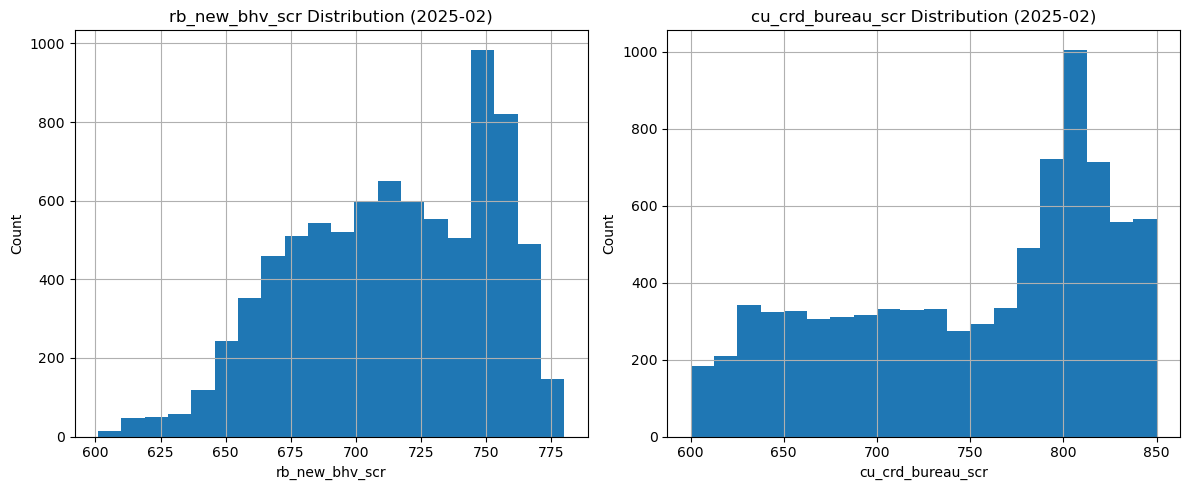

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
df_feb = merged_df_risk[merged_df_risk['billing_cycle_date'] == '2025-02']
df_feb = df_feb[(df_feb['rb_new_bhv_scr'] >= 600) & (df_feb['rb_new_bhv_scr'] <= 900)]
df_feb = df_feb[(df_feb['cu_crd_bureau_scr'] >= 600) & (df_feb['cu_crd_bureau_scr'] <= 900)]

# 繪製 rb_new_bhv_scr 和 cu_crd_bureau_scr 的分布圖
plt.figure(figsize=(12, 5))

# subplot 1: rb_new_bhv_scr
plt.subplot(1, 2, 1)
df_feb['rb_new_bhv_scr'].hist(bins=20)
plt.title('rb_new_bhv_scr Distribution (2025-02)')
plt.xlabel('rb_new_bhv_scr')
plt.ylabel('Count')

# subplot 2: cu_crd_bureau_scr
plt.subplot(1, 2, 2)
df_feb['cu_crd_bureau_scr'].hist(bins=20)
plt.title('cu_crd_bureau_scr Distribution (2025-02)')
plt.xlabel('cu_crd_bureau_scr')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


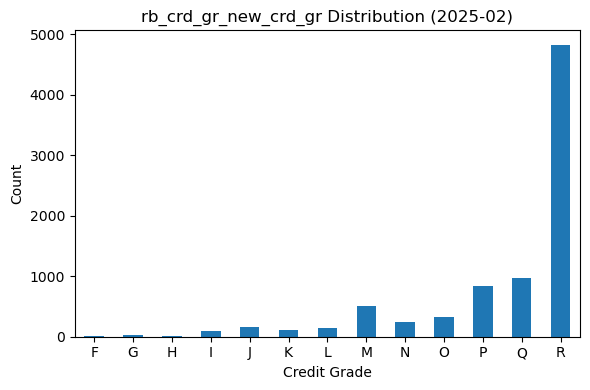

In [25]:
plt.figure(figsize=(6, 4))
df_feb['rb_crd_gr_new_crd_gr'].value_counts().sort_index().plot(kind='bar')
plt.title('rb_crd_gr_new_crd_gr Distribution (2025-02)')
plt.xlabel('Credit Grade')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

overutilization_flag（使用率過高風險標記）

In [26]:
merged_df_risk['overutilization_flag'] = (merged_df_risk['ca_current_utilz'] > 95).astype(int)

In [27]:
merged_df_risk['ca_current_utilz'].describe()

count    51172.000000
mean         0.313364
std          0.333510
min         -1.140000
25%          0.040000
50%          0.170000
75%          0.530000
max          1.910000
Name: ca_current_utilz, dtype: float64

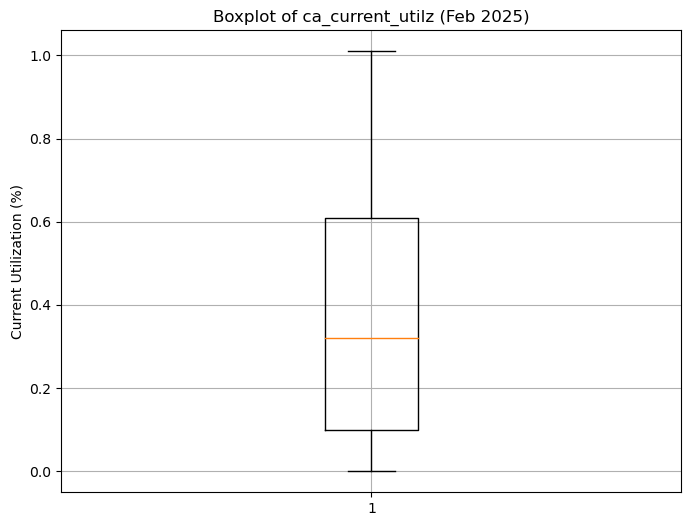

In [28]:
df_feb = merged_df_risk[merged_df_risk['billing_cycle_date'] == '2025-02']
df_feb = df_feb[(df_feb['cu_crd_bureau_scr'] >= 0) & (df_feb['cu_crd_bureau_scr'] <= 1)]

plt.figure(figsize=(8, 6))
plt.boxplot(df_feb['ca_current_utilz'].dropna(), vert=True)
plt.title('Boxplot of ca_current_utilz (Feb 2025)')
plt.ylabel('Current Utilization (%)')
plt.grid(True)
plt.show()

### 3. RFM & Risk Group Creation

Merge the data into 2024 Q4

In [29]:
target_months = [pd.Period('2024-10', freq='M'),
                pd.Period('2024-11', freq='M'),
                pd.Period('2024-12', freq='M')]

df_q4 = merged_df_risk[merged_df_risk['billing_cycle_date'].isin(target_months)]

In [30]:
drop_cols = [
    'return_check_cnt_2yr', 'return_check_cnt_last_mth', 'return_check_cnt_py',
    'return_check_cnt_total', 'return_check_cnt_ytd', 'cu_processing_date',
    'cu_nbr_days_dlq', 'cu_cur_nbr_due', 'ca_max_dlq_lst_6_mnths', 'ca_nsf_count_lst_12_months',
    'cu_line_incr_excl_flag', 'cu_nbr_of_plastics', 'client_id', 'card_activation_flag',
    'external_status_reason_code', 'ext_status_reason_cd_desc', 'account_card_type',
    'open_date_year_month', 'card_activation_date_year_month','cu_cash_line_am',
    'case_id', 'transaction_dt', 'reported_date', 'gross_fraud_amt', 'ds_id'
]
df_q4.drop(columns=drop_cols, inplace=True, errors='ignore')

In [31]:
december_df = df_q4[df_q4['billing_cycle_date'] == '2024-12'][
    ['current_account_nbr', 'ca_avg_utilz_lst_3_mnths', 'ca_avg_utilz_lst_6_mnths', 'rb_crd_gr_new_crd_gr']
].set_index('current_account_nbr')

In [32]:
agg_dict = {
    'prev_balance': 'mean',
    'cu_cur_balance': 'mean',
    'cu_crd_line': 'mean',
    'cu_otb': 'mean',
    'ca_current_utilz': 'mean',
    'rb_new_bhv_scr': 'mean',
    'cu_crd_bureau_scr': 'mean',
    'mo_tot_sales_array_1': 'mean',
    'mo_tot_sales_array_2': 'mean',
    'mo_tot_sales_array_3': 'mean',
    'mo_tot_sales_array_4': 'mean',
    'mo_tot_sales_array_5': 'mean',
    'mo_tot_sales_array_6': 'mean',
    'fraud_flag': 'max',
    'external_risk_flag': 'max',
    'delinquency_flag': 'max',
    'return_check_flag': 'max',
    'overutilization_flag': 'max',
}
df_q4_summary = df_q4.groupby('current_account_nbr').agg(agg_dict).round(4)
df_q4_summary = df_q4_summary.join(december_df, on='current_account_nbr')
df_q4_summary = df_q4_summary.reset_index()

In [33]:
df_q4_summary.head()

,current_account_nbr,prev_balance,cu_cur_balance,cu_crd_line,cu_otb,ca_current_utilz,rb_new_bhv_scr,cu_crd_bureau_scr,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,fraud_flag,external_risk_flag,delinquency_flag,return_check_flag,overutilization_flag,ca_avg_utilz_lst_3_mnths,ca_avg_utilz_lst_6_mnths,rb_crd_gr_new_crd_gr
0,00iP5U82D8XwVQ9G,512.1233,632.3567,3500.0,2887.6433,0.1733,739.0000,788.0,616.8500,536.6167,460.0733,347.5200,259.1967,206.7633,0,0,0,0,0,0.17,0.12,R
1,033o9yHYen3xoz6k,2156.6900,2352.3467,15000.0,12667.6533,0.1567,746.0000,802.0,2332.3467,2176.6900,1832.2367,1609.2800,1517.7233,1448.7567,0,0,0,0,0,0.15,0.13,R
2,034bM166vNmgLiIA,468.7400,753.6133,1100.0,366.3867,0.6667,689.6667,646.0,392.4667,383.6033,519.7633,357.0933,326.2000,0.0000,0,0,0,0,0,0.66,0.49,N
3,03cqv0gFjEIiQG0x,-20.0000,1192.3400,2500.0,1327.6600,0.4700,653.0000,654.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0,0.47,0.48,M
4,03n28YA8ljfM9tor,147.6367,20.7000,2000.0,1999.3000,0.0000,680.3333,777.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,1,0,0,0.00,0.12,R


Import the RFM dataset

In [34]:
RFM_raw_df= pd.read_csv("df_full.csv")
RFM_df = RFM_raw_df[['current_account_nbr','month','RFM_Score']]
target_months = ['2024-10', '2024-11', '2024-12']
RFM_q4 = RFM_df[RFM_df['month'].isin(target_months)]
RFM_q4_unique = RFM_q4.drop_duplicates(subset='current_account_nbr', keep='first').copy()
RFM_q4_unique['month'] = 'Q4'
print(RFM_q4_unique.shape)
RFM_q4_unique.head()

(8736, 3)


,current_account_nbr,month,RFM_Score
4,xYaLrD9IvmbVl1PB,Q4,125
6,JM78WNziiRWgmL8e,Q4,224
13,bv4NLVhWTGCf8KgC,Q4,222
17,nb2pG80DDq4ucyZI,Q4,443
31,kqrsB4FtU00uXpWU,Q4,344


In [35]:
inconsistent_rfm = RFM_df.groupby('current_account_nbr')['RFM_Score'].nunique().reset_index()
inconsistent_rfm = inconsistent_rfm[inconsistent_rfm['RFM_Score'] > 1]
print(f"There are {len(inconsistent_rfm)} accounts with inconsistent RFM scores")
inconsistent_rfm.head()

There are 0 accounts with inconsistent RFM scores


,current_account_nbr,RFM_Score


In [36]:
# RFM_q4_unique.to_csv("RFM_q4_unique.csv",index=False)

In [37]:
RFM_q4 = RFM_q4_unique.copy()
RFM_q4.shape

(8736, 3)

In [38]:
df_q4_rfm = df_q4_summary.merge(
    RFM_q4,
    on=['current_account_nbr'],
    how='left'
)
df_q4_rfm = df_q4_rfm.dropna(subset=['RFM_Score'])
df_q4_rfm['RFM_Score'] = df_q4_rfm['RFM_Score'].astype('int')
df_q4_rfm['RFM_Score'] = df_q4_rfm['RFM_Score'].astype('str')
df_q4_rfm.shape

(7110, 24)

In [39]:
risk_counts = df_q4_rfm[['fraud_flag', 'external_risk_flag', 'delinquency_flag', 'return_check_flag', 'overutilization_flag']].sum()
risk_summary = risk_counts.reset_index()
risk_summary.columns = ['Risk_Flag', 'Count']
risk_summary

,Risk_Flag,Count
0,fraud_flag,5
1,external_risk_flag,308
2,delinquency_flag,925
3,return_check_flag,419
4,overutilization_flag,0


In [40]:
risk_flags = ['fraud_flag', 'external_risk_flag', 'delinquency_flag', 'return_check_flag', 'overutilization_flag']
df_q4_rfm['risk_group'] = df_q4_rfm[risk_flags].sum(axis=1).apply(lambda x: 'High Risk' if x > 0 else 'Low Risk')

In [41]:
df_q4_rfm['risk_group'].value_counts()

risk_group
Low Risk     5672
High Risk    1438
Name: count, dtype: int64

In [42]:
df_q4_rfm.head()

,current_account_nbr,prev_balance,cu_cur_balance,cu_crd_line,cu_otb,ca_current_utilz,rb_new_bhv_scr,cu_crd_bureau_scr,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,fraud_flag,external_risk_flag,delinquency_flag,return_check_flag,overutilization_flag,ca_avg_utilz_lst_3_mnths,ca_avg_utilz_lst_6_mnths,rb_crd_gr_new_crd_gr,month,RFM_Score,risk_group
0,00iP5U82D8XwVQ9G,512.1233,632.3567,3500.0,2887.6433,0.1733,739.0000,788.0000,616.8500,536.6167,460.0733,347.5200,259.1967,206.7633,0,0,0,0,0,0.17,0.12,R,Q4,455,Low Risk
1,033o9yHYen3xoz6k,2156.6900,2352.3467,15000.0,12667.6533,0.1567,746.0000,802.0000,2332.3467,2176.6900,1832.2367,1609.2800,1517.7233,1448.7567,0,0,0,0,0,0.15,0.13,R,Q4,555,Low Risk
2,034bM166vNmgLiIA,468.7400,753.6133,1100.0,366.3867,0.6667,689.6667,646.0000,392.4667,383.6033,519.7633,357.0933,326.2000,0.0000,0,0,0,0,0,0.66,0.49,N,Q4,355,Low Risk
5,049sX01uVFhaa0i2,7396.9100,7166.4367,15000.0,7853.5633,0.4767,713.3333,795.6667,2057.4367,2614.5500,2524.4400,2533.4200,2141.6133,2029.4600,0,0,0,1,0,0.47,0.38,R,Q4,555,High Risk
7,05AfSsd6epxXiK01,6351.8533,6402.2033,15000.0,8617.7967,0.4267,726.6667,840.0000,6493.7700,6459.3800,6957.9633,7563.8967,5188.8233,5155.4600,0,0,0,0,0,0.42,0.46,R,Q4,555,Low Risk


In [43]:
rfm_counts = df_q4_rfm['RFM_Score'].value_counts().reset_index()
rfm_counts.columns = ['RFM_Score', 'Count']
rfm_counts.head()

,RFM_Score,Count
0,555,2274
1,455,599
2,122,232
3,111,183
4,355,172


In [44]:
valid_scores = rfm_counts[rfm_counts['Count'] >= 8.5]['RFM_Score']
df_q4_rfm_filtered = df_q4_rfm[df_q4_rfm['RFM_Score'].isin(valid_scores)]

In [45]:
top_20_rfm = df_q4_rfm_filtered['RFM_Score'].value_counts().head(20).index.tolist()
filtered_df = df_q4_rfm_filtered[df_q4_rfm_filtered['RFM_Score'].isin(top_20_rfm)]
filtered_dist = filtered_df.groupby(['RFM_Score', 'risk_group']).size().reset_index(name='count')
total_per_rfm = filtered_dist.groupby('RFM_Score')['count'].transform('sum')
filtered_dist['percentage'] = filtered_dist['count'] / total_per_rfm

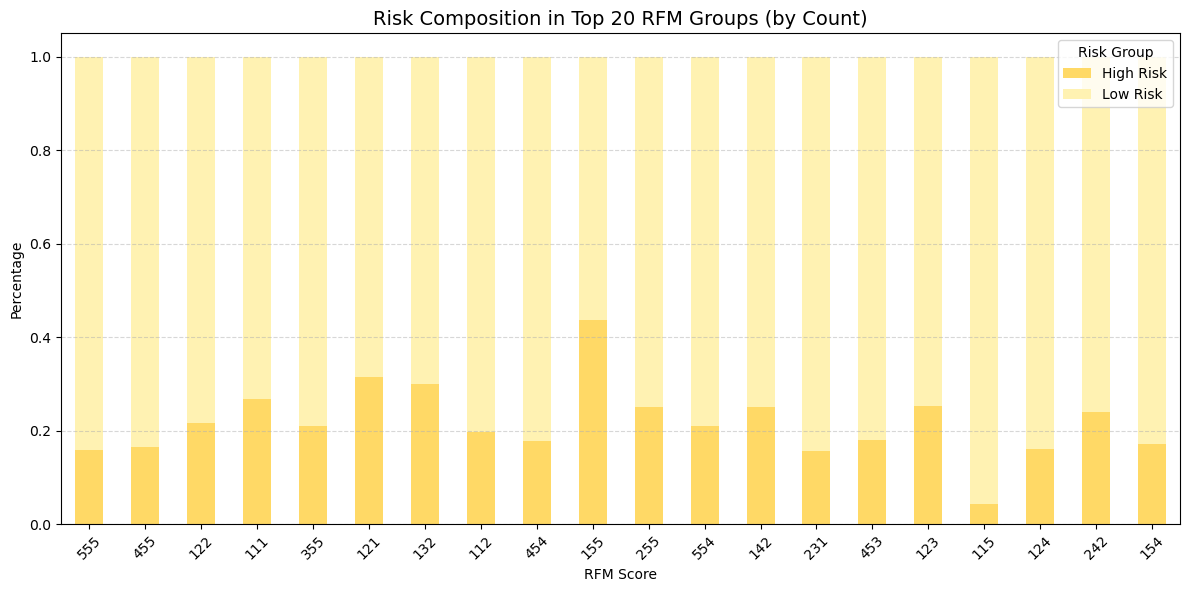

In [46]:
pivot_data_filtered = filtered_dist.pivot(index='RFM_Score', columns='risk_group', values='percentage').fillna(0)
pivot_data_filtered = pivot_data_filtered.loc[top_20_rfm] 

custom_colors = ['#FFD966','#FFF2B2']  # light yellow and deeper yellow

pivot_data_filtered.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=custom_colors
)
plt.title('Risk Composition in Top 20 RFM Groups (by Count)', fontsize=14)
plt.ylabel('Percentage')
plt.xlabel('RFM Score')
plt.legend(title='Risk Group')
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Calculate the proportion of High/Low Risk for each R, F, and M score separately

In [47]:
df_q4_rfm_filtered[['R', 'F', 'M']] = df_q4_rfm_filtered['RFM_Score'].astype(str).apply(lambda x: pd.Series(list(x)))
df_q4_rfm_filtered[['R', 'F', 'M']] = df_q4_rfm_filtered[['R', 'F', 'M']].astype(int)

# 分別計算 R, F, M 分數對應的 High/Low Risk 占比
def compute_risk_distribution_by_component(component):
    df_grouped = df_q4_rfm_filtered.groupby([component, 'risk_group']).size().reset_index(name='count')
    total_per_group = df_grouped.groupby(component)['count'].transform('sum')
    df_grouped['percentage'] = df_grouped['count'] / total_per_group
    return df_grouped

risk_by_R = compute_risk_distribution_by_component('R')
risk_by_F = compute_risk_distribution_by_component('F')
risk_by_M = compute_risk_distribution_by_component('M')

In [48]:
# 計算每個 RFM 群體內的風險結構分布
risk_distribution = df_q4_rfm_filtered.groupby(['RFM_Score', 'risk_group']).size().reset_index(name='count')

# 將資料轉成百分比形式
total_per_rfm = risk_distribution.groupby('RFM_Score')['count'].transform('sum')
risk_distribution['percentage'] = risk_distribution['count'] / total_per_rfm
risk_distribution_high = risk_distribution[risk_distribution['risk_group']=='High Risk']

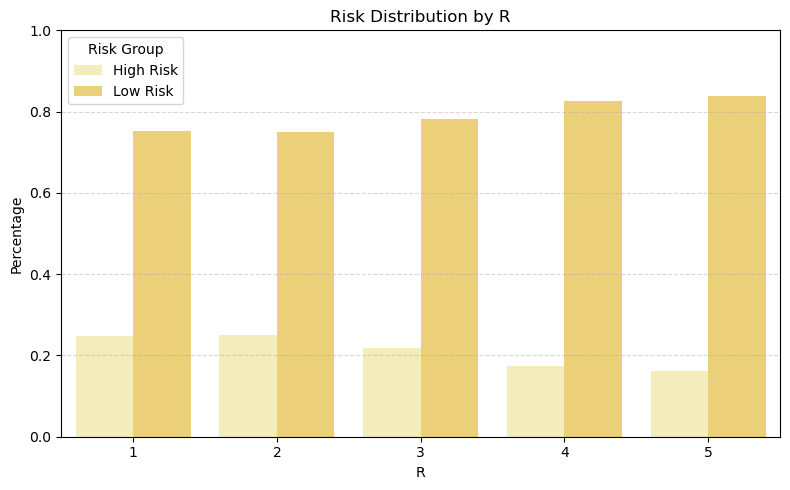

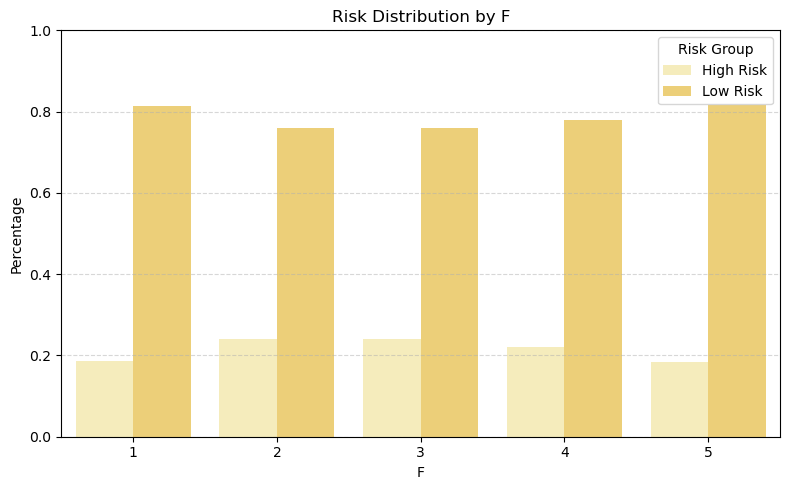

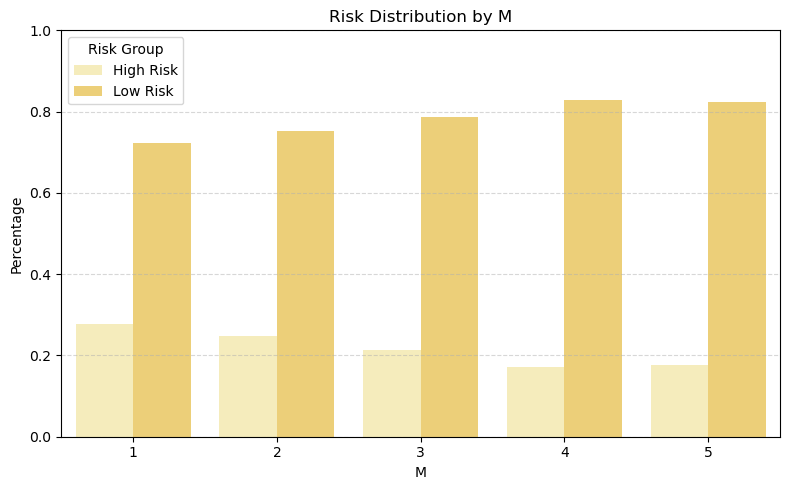

In [49]:
def plot_risk_distribution(df, component_label):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x=component_label, y='percentage', hue='risk_group', palette=['#FFF2B2', '#FFD966'])
    plt.title(f'Risk Distribution by {component_label}')
    plt.ylabel('Percentage')
    plt.xlabel(component_label)
    plt.ylim(0, 1)
    plt.legend(title='Risk Group')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 畫出三張圖：R, F, M
plot_risk_distribution(risk_by_R, 'R')
plot_risk_distribution(risk_by_F, 'F')
plot_risk_distribution(risk_by_M, 'M')

### 4. 2025 Recommended Credit Line ​

In [50]:
sales_cols = [
    'mo_tot_sales_array_1', 'mo_tot_sales_array_2', 'mo_tot_sales_array_3',
    'mo_tot_sales_array_4', 'mo_tot_sales_array_5', 'mo_tot_sales_array_6'
]
df_q4_rfm['avg_sales'] = df_q4_rfm[sales_cols].mean(axis=1)

In [51]:
df_q4_rfm['expected_q4_spending'] = (
    df_q4_rfm['prev_balance'] * 0.25 +
    df_q4_rfm['cu_cur_balance'] * 0.25 +
    df_q4_rfm['avg_sales'] * 0.5
) * (1 + df_q4_rfm['ca_current_utilz'])
df_q4_rfm['expected_q4_spending'] = df_q4_rfm['expected_q4_spending'].round(4)

- Comprehensive Spending Base
    - Field Name	Weight	Description
    - prev_balance	25%	Monthly statement balance, reflecting past behavior related to statement-based spending
    - cu_cur_balance	25%	Current outstanding balance, representing the amount still unpaid and ongoing borrowing activity (indicates activeness)
    - avg_sales	50%	Average actual credit card spending over the past 6 months, reflecting daily shopping behavior

In [52]:
def recommend_credit(row):
    if row['risk_group'] == 'Low Risk':
        return row['expected_q4_spending'] * 1.3
    else:
        return row['expected_q4_spending'] * 0.8

df_q4_rfm['recommended_credit_line'] = df_q4_rfm.apply(recommend_credit, axis=1)

[Using RFM as Segmentation]

- Risk Level	Buffer Multiplier	Description
- Low Risk	× 1.3	Potential users; credit limit can be moderately increased
- High Risk	× 0.8	Conservative limit control to avoid over-lending

In [53]:
def compute_group_credit(sub_df):
    avg_spending = sub_df['expected_q4_spending'].median()
    buffer = 1.3 if sub_df['risk_group'].iloc[0] == 'Low Risk' else 0.8
    return avg_spending * buffer

rfm_risk_credit_summary = df_q4_rfm.groupby(['RFM_Score', 'risk_group']).apply(compute_group_credit).reset_index()
rfm_risk_credit_summary.columns = ['RFM_Score', 'risk_group', 'group_recommended_credit_line']
rfm_risk_credit_summary['group_recommended_credit_line'] = rfm_risk_credit_summary['group_recommended_credit_line'].round(2)

In [54]:
rfm_risk_credit_summary.head()

,RFM_Score,risk_group,group_recommended_credit_line
0,111,High Risk,95.83
1,111,Low Risk,53.09
2,112,High Risk,113.61
3,112,Low Risk,178.27
4,113,High Risk,255.73


In [55]:
rfm_predict = pd.read_csv("top_predictions_RFM.csv")

In [56]:
rfm_predict

,original_rfm,most_likely_predicted_rfm
0,111,111
1,112,112
2,113,111
3,114,111
4,115,111
...,...,...
115,545,555
116,552,453
117,553,455
118,554,455


In [57]:
rfm_risk_credit_summary

,RFM_Score,risk_group,group_recommended_credit_line
0,111,High Risk,95.83
1,111,Low Risk,53.09
2,112,High Risk,113.61
3,112,Low Risk,178.27
4,113,High Risk,255.73
...,...,...,...
216,553,Low Risk,282.91
217,554,High Risk,348.66
218,554,Low Risk,429.08
219,555,High Risk,2110.18


In [58]:
rfm_risk_credit_summary['RFM_Score'] = rfm_risk_credit_summary['RFM_Score'].astype(str)
rfm_predict['original_rfm'] = rfm_predict['original_rfm'].astype(str)
rfm_predict['most_likely_predicted_rfm'] = rfm_predict['most_likely_predicted_rfm'].astype(int)
rfm_predict['most_likely_predicted_rfm'] = rfm_predict['most_likely_predicted_rfm'].astype(str)
rfm_updated = pd.merge(
    rfm_risk_credit_summary,
    rfm_predict,
    how="left",
    left_on="RFM_Score",
    right_on="original_rfm"
)
rfm_updated = rfm_updated.drop(columns=['original_rfm'])

In [59]:
# Create a lookup dictionary from the original RFM + risk_group to credit line
lookup = rfm_updated.set_index(["RFM_Score", "risk_group"])["group_recommended_credit_line"].to_dict()

# Define a function to fetch predicted credit line
def get_predicted_credit_line(row):
    key = (row["most_likely_predicted_rfm"], row["risk_group"])
    return lookup.get(key, None)

# Apply the function to generate the new column
rfm_updated["predict_credit_line"] = rfm_updated.apply(get_predicted_credit_line, axis=1)
rfm_updated.rename(columns={
    "group_recommended_credit_line": "orignal_purchase_index",
    "predict_credit_line": "recommended_credit_line"}, inplace=True)

In [60]:
rfm_updated.head()

,RFM_Score,risk_group,orignal_purchase_index,most_likely_predicted_rfm,recommended_credit_line
0,111,High Risk,95.83,111,95.83
1,111,Low Risk,53.09,111,53.09
2,112,High Risk,113.61,112,113.61
3,112,Low Risk,178.27,112,178.27
4,113,High Risk,255.73,111,95.83


In [61]:
# rfm_updated.to_csv("rfm_predict_credit_line.csv",index=False)

In [62]:
rfm_updated["credit_line_change"] = rfm_updated["recommended_credit_line"] - rfm_updated["orignal_purchase_index"]
rfm_updated["credit_line_trend"] = rfm_updated["credit_line_change"].apply(
    lambda x: "increase" if x > 0 else ("decrease" if x < 0 else "no change")
)
trend_proportion = rfm_updated["credit_line_trend"].value_counts(normalize=True).reset_index()
trend_proportion.columns = ["credit_line_trend", "proportion"]
trend_proportion

,credit_line_trend,proportion
0,decrease,0.737557
1,increase,0.199095
2,no change,0.063348


In [63]:
# Calculate average change per risk group
avg_change_by_risk = rfm_updated.groupby("risk_group")["credit_line_change"].mean().reset_index()
avg_change_by_risk

,risk_group,credit_line_change
0,High Risk,-299.937172
1,Low Risk,-302.386228


In [64]:
top_20_df = rfm_updated[rfm_updated["RFM_Score"].isin(top_20_rfm)]
rfm_credit_change = top_20_df.groupby(["RFM_Score","risk_group"])[["orignal_purchase_index", "recommended_credit_line", "credit_line_change"]].mean().reset_index()
rfm_credit_change_sorted = rfm_credit_change.sort_values(by="credit_line_change", ascending=False)
rfm_credit_change_sorted.head()

,RFM_Score,risk_group,orignal_purchase_index,recommended_credit_line,credit_line_change
29,355,Low Risk,1176.34,3335.36,2159.02
27,255,Low Risk,1331.51,3335.36,2003.85
35,455,Low Risk,1622.44,3335.36,1712.92
33,454,Low Risk,344.20,1622.44,1278.24
31,453,Low Risk,383.96,1622.44,1238.48


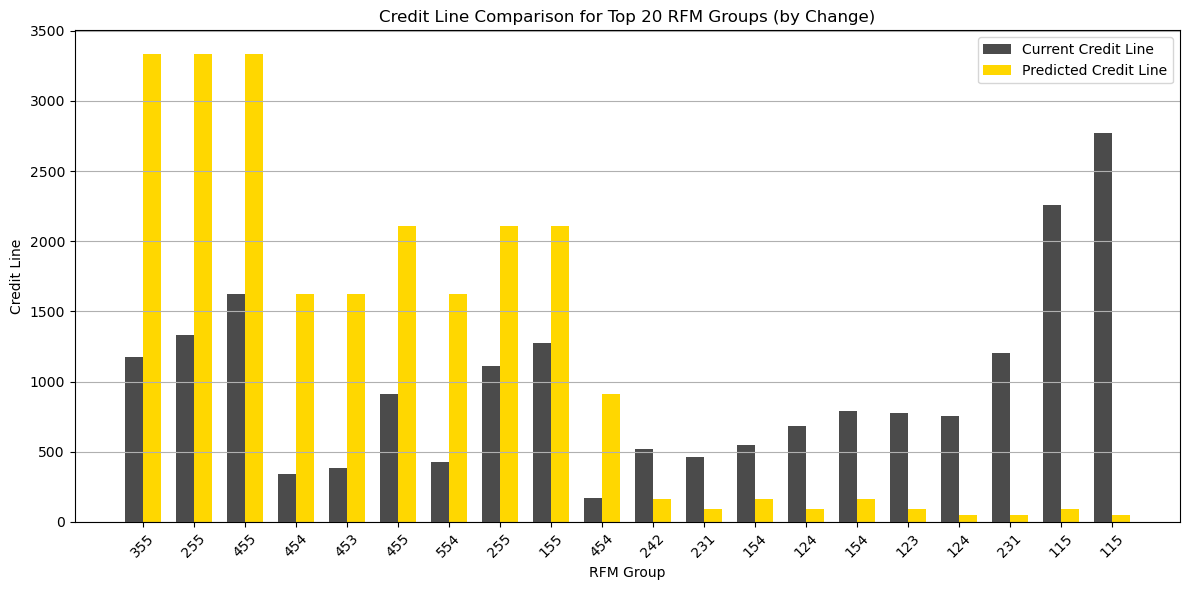

In [65]:
top_positive_change = rfm_credit_change_sorted.head(10)
top_negative_change = rfm_credit_change_sorted.tail(10)

top_changes = pd.concat([top_positive_change, top_negative_change])
top_changes["RFM_Score"] = top_changes["RFM_Score"].astype(str)


fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(top_changes))

plt.bar(index, top_changes["orignal_purchase_index"], bar_width, label="Current Credit Line", color="#4B4B4B")
plt.bar([i + bar_width for i in index], top_changes["recommended_credit_line"], bar_width, label="Predicted Credit Line", color="#FFD700")
plt.xlabel("RFM Group")
plt.ylabel("Credit Line")
plt.title("Credit Line Comparison for Top 20 RFM Groups (by Change)")
plt.xticks([i + bar_width / 2 for i in index], top_changes["RFM_Score"], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()
